# Field‑Aware MACE MD Simulation with ASE

This notebook demonstrates how to perform a molecular‑dynamics (MD) simulation under a time‑varying electric field using ASE and the field‑aware MACE potential. It is organized into:

1. **Setup**  
   - Imports, constants, and utility functions  
2. **MaterialFetcher**  
   - Class to pull and prepare a periodic structure from MP  
3. **MACEFieldMD**  
   - Class encapsulating the MD setup, field schedule, and trajectory logging  
4. **Run Example**  
   - Instantiate the classes and run a 10 ps NVT MD at 300 K with sinusoidal field  

---

In [1]:
# Imports and Constants
import random
import nglview as nv
from ase.io import read
import numpy as np
import torch

from MaterialFetcher import MaterialFetcher
from MACEFieldMD import MACEFieldMD
from Spectroscopy import Spectroscopy

# Set random seed for reproducibility
random.seed(1)

/home/brad/miniconda3/envs/mace-field/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


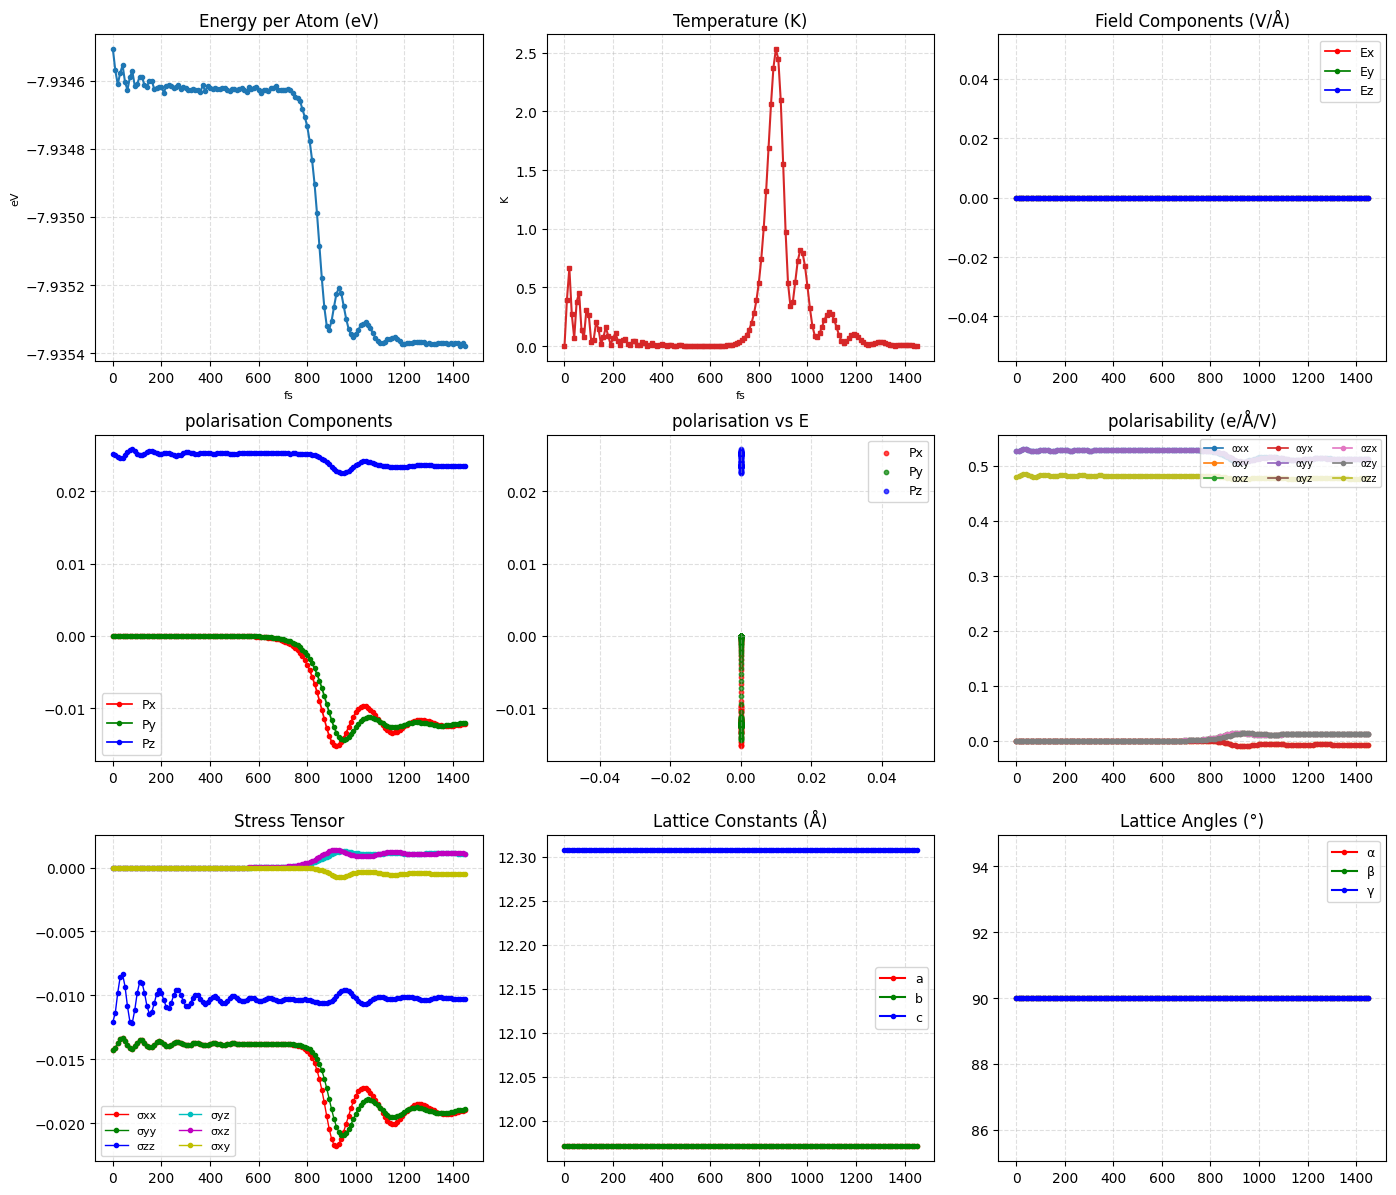

KeyboardInterrupt: 

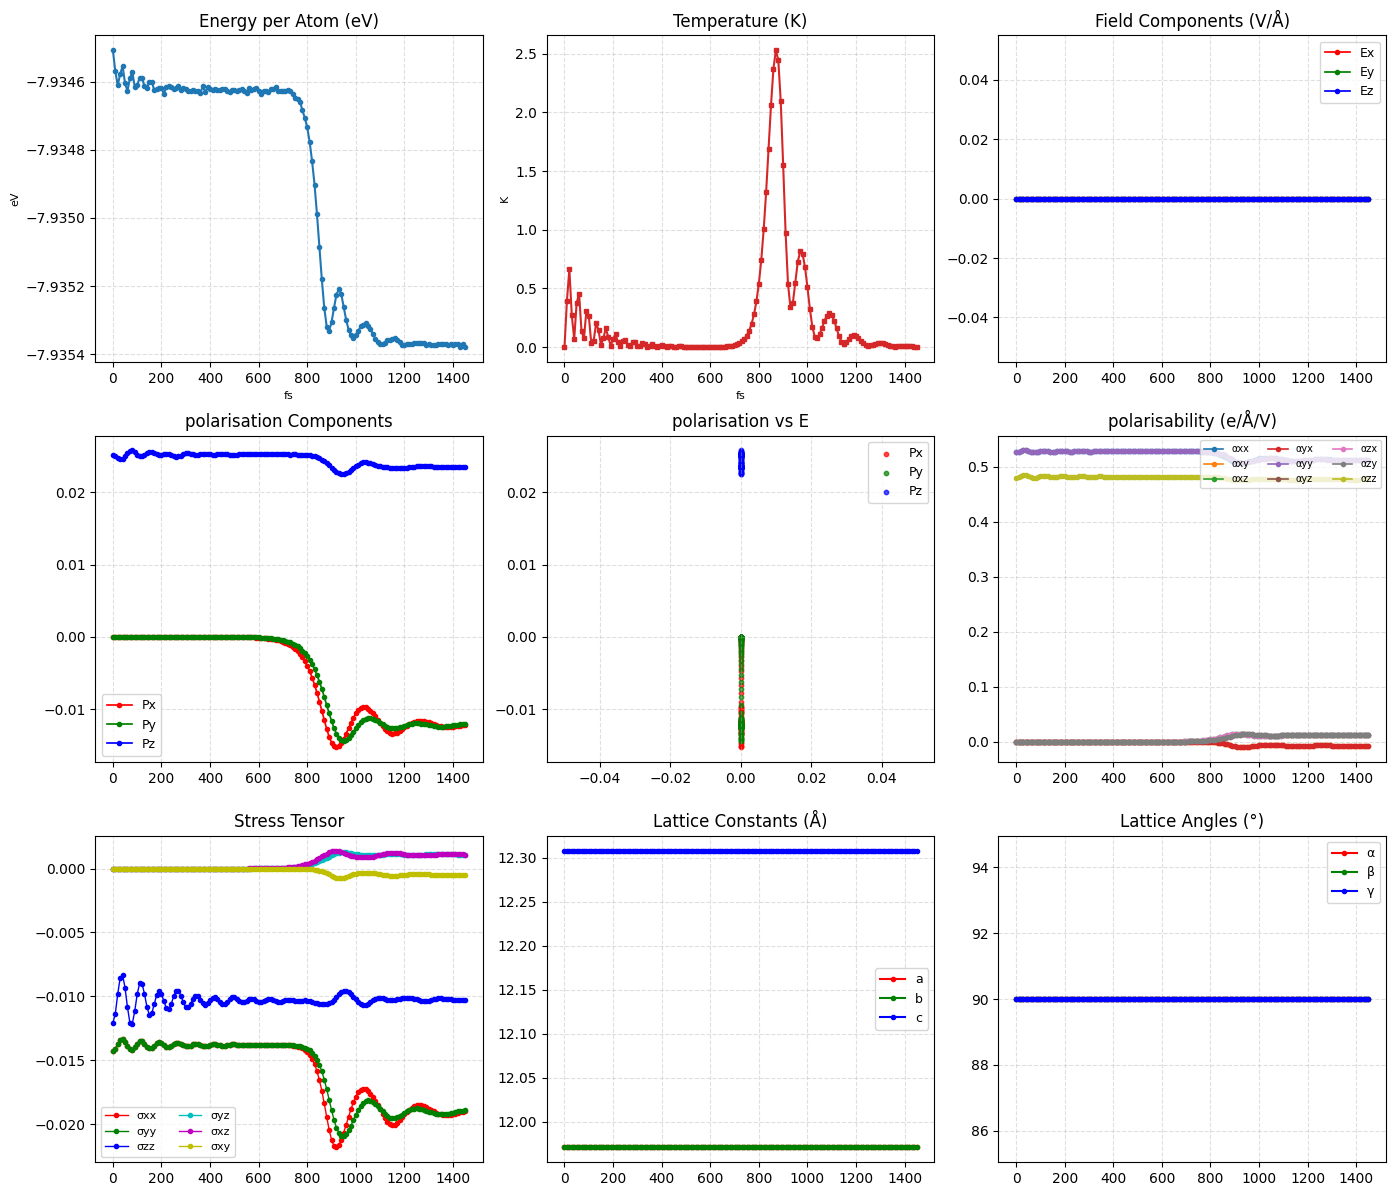

In [4]:
# Instantiate and run MD
API_KEY = "J0JE22k0f7XptxXUH0ofSLr0XQTRuIIm"
MP_ID   = "mp-5986"           # replace with any mp-id
SUPER   = (3,3,3)

# Fetch structure
fetcher = MaterialFetcher(api_key=API_KEY)
info = fetcher.fetch(MP_ID, supercell=SUPER)

# restart = read("MD/SiO2-mp-7000/SiO2-mp-7000_trace-2.xyz", "-1")
# from ase.io import write
# write("MD/SiO2-mp-7000/SiO2-mp-7000.xyz", restart)

# info = {}

# info["xyz"] = "MD/SiO2-mp-7000/SiO2-mp-7000.xyz"

def electric_field(step, t_fs):
    if step < 200:
        return np.array([0.0, 0.0, 0.0])
    else:
        return [0.0, 0.0, 0.30 * np.sin(2*np.pi*t_fs/1000)]

# Run with live‑plotting turned on
md = MACEFieldMD(
    model_path="mace-field-mp-0b3-medium-mh.model",
    dtype="float32",
    head="pt_head",
    device="cpu"
)
logs, traj_path = md.run(
    xyz_path=info["xyz"],
    temperature=0.0,
    timestep_fs=1.0,
    total_steps=10000,
    log_interval=10,
    field_func=electric_field,
    visualize=True   # <-- enable live plotting
)

traj = read(traj_path , ":")  # use actual path
view = nv.NGLWidget(nv.ASETrajectory(traj))
view.center()
view

In [ ]:
# Material-specific configurations
config = {
    "file_mlmd": traj_path,
    "ωi": 0,
    "ωf": 20,
    "temp": 1,
    "do_IR": True,
    "do_Raman": True
}

spec = Spectroscopy(
    file_mlmd=config["file_mlmd"],
    temp=config["temp"],
    ωi=config["ωi"],
    ωf=config["ωf"],
    do_IR=config["do_IR"],
    do_Raman=config["do_Raman"]
)

spec.plot_autocorr_P()
spec.plot_autocorr_α()
spec.plot_IR()
spec.plot_raman()
spec.plot_ε()